# Playing Azul with Deep Reinforcement Learning

Deep reinforcement learning is a technique that combines deep neural networks and reinforcement learning, and it could largely improve the accuracy and precision of some policy-making models. [This paper](https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd?fbclid=IwAR1CiRCE0a5nrZBQs2A2Ezw3fh3VUg7JWFC0m8ZKNDIp4xOzqPuhUmTgYQk), titled "A general reinforcement learning algorithm that masters chess, shogi and Go through self-play", showed how this was possible in a groundbreaking achievement of reinforcement learning. In this homework, you will re-implement some of the key parts of this paper to train an agent that learns to play new games.

## 1. Basic Structure (with Tic-Tac-Toe as an example)

For the approach described in the paper, the deep neural network learns a map:

$$f(s; \theta) = (p, v).$$
        
The map (with parameters $\theta$) takes in a state $s$ and outputs a vector of move probabilities $p$ and an estimate of the outcome $v$. The vector of probabilities $p$ is called a *policy*.



In [ ]:
!pip install jax
!pip install flax
!pip install optax
!pip install networkx

In [1]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax import traverse_util
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import matplotlib.pyplot as plt
import networkx as nx

### 1) Simulating the Game

You will need to first implement the `get_next_state` and `get_reward` functions. The following information will be useful:


*   The tic-tac-toe board is represented by a 9x1 vector that would be a row-major representation of the 3x3 board.
*   Each entry in that vector is either 0 (empty), 1 (marked by player 1), or -1 (marked by player 2).
*   An action is simply the index of our 9x1 vector that we would like to mark.

In [2]:
def init_board():
  return np.zeros((3, 3), dtype=int).flatten()

def flip_board(board):
  # Used to change the current player
  return -board

def get_valid_mask(board):
  return board == 0

def get_next_state(board, action):
  ################################################################################################
  # TODO: Return the state that would result in taking the given action using the given board
  # Hint: Always assume the action is made by player 1
  ################################################################################################
  if(board[action] == 1 or board[action] == -1): # Under what conditions would the given action be illegal?
    print("Illegal Move")
    print(board.reshape((3,3)))
    print(action)
    print(get_reward(board))
    assert False
  next_board = board.copy()
  next_board[action] = 1
  ################################################################################################
  # END OF YOUR CODE
  ################################################################################################
  return next_board

def sample_action(action_dist):
  # Randomly choose an action
  action_dist = action_dist.flatten() / action_dist.sum()
  return np.random.choice(action_dist.shape[0], p=action_dist)

def disp_board(board):
  # Used to display the board
  plt.imshow(board)

diag_mask = np.eye(3)
ld_mask = np.eye(3)[::-1, :]
def get_reward(board):
  ################################################################################################
  # TODO: Implement the reward function. We first calculate whether there is a win diagonally,
  # horizontally, or vertically. Then we return the reward and whether or not the game has ended.
  ################################################################################################
  b = board.reshape((3,3))
  diag = np.sum(diag_mask*b) <= -3
  diag_l = np.sum(ld_mask*b) <= -3
  row = np.min(b@np.ones(3)) <= -3
  col = np.min(b.T@np.ones(3)) <= -3
  reward = -int(diag or diag_l or row or col)
  return reward, (reward != 0 or (board == 0).sum() == 0) # Remember the game can end without a win
  ################################################################################################
  # END OF YOUR CODE
  ################################################################################################

Run the following cell to test the basic functinoality of the get_next_state and get_reward functions. 

In [3]:
for _ in range(200):
  board = init_board()
  for _ in range(10):
    action_dist = np.ones(board.shape) * get_valid_mask(board)
    next_action = sample_action(action_dist)
    board = flip_board(get_next_state(board, next_action))
    reward, game_over = get_reward(board)
    if(game_over):
      break
print ("No issues encountered!")

No issues encountered!


### 2) Monte Carlo Tree Search

This essay uses Monte Carlo Tree Search(MCTS) algorithm, which need to be implemented in the below.

Each round of Monte Carlo tree search consists of four steps:

**Selection**: Start from root $R$ and select successive child nodes until a leaf node $L$ is reached. The root is the current game state and a leaf is any node that has a potential child from which no simulation (playout) has yet been initiated.

**Expansion**: Unless $L$ ends the game decisively (e.g. win/loss/draw) for either player, create one (or more) child nodes and choose node $C$ from one of them. Child nodes are any valid moves from the game position defined by $L$.

**Simulation**: Complete one random playout from node $C$. This step is sometimes also called playout or rollout. A playout may be as simple as choosing uniform random moves until the game is decided (for example in chess, the game is won, lost, or drawn).

**Backpropagation**: Use the result of the playout to update information in the nodes on the path from $C$ to $R$.

From the AlphaZero paper: Each state-action pair $(s, a)$ stores a set of statistics, $\{N(s, a), W(s, a), Q(s, a), P(s, a)\}$, where $N(s, a)$ is the visit count, $W(s, a)$ is the total action-value, $Q(s, a)$ is the mean action-value, and $P(s, a)$ is the prior probability of selecting $a$ in $s$. Each simulation begins at the root node of the search tree, $s_0$, and finishes when the simulation reaches a leaf node $s_L$ at time-step $L$. At each of these timesteps, $t < L$, an action is selected, $a_t = argmax_a(Q(s_t, a) + U(s_t, a))$, using a variant of the PUCT algorithm, $U(s, a) = C(s)P(s, a)\sqrt{N(s)}/(1 + N(s, a))$, where $N(s)$ is
the parent visit count and $C(s)$ is the exploration rate, which grows slowly with search time, $C(s) = log ((1 + N(s) + c_{base})/c_{base}) + c_{init}$, but is essentially constant during the fast training games.

The stochastic policy obtained after performing the MCTS uses exponentiated counts, i.e. 
$$π(s)=N(s,⋅)^{1/τ}/∑_b(N(s,b)^{1/τ})$$, where $τ$ is the temperature and controls the degree of exploration. AlphaGo Zero uses $τ = 1$ (simply the normalised counts) for the first 30 moves of each game, and then sets it to an infinitesimal value (picking the move with the maximum counts).

In [4]:
def toy_model(state):
    return np.ones(state.shape) / state.shape[0], 0.0123

STATE_DIM = 9 #Dimension of 4x4 tic-tac-toe board
ACTION_DIM = 9
MAX_SIZE = int(1e3)
C_BASE, C_INIT = 3.0, 1.0
class MCTS:
    def __init__(self, max_size=MAX_SIZE, exp_rate=3.0):
        self.state = np.zeros((max_size, STATE_DIM))
        self.state_lookup = {} #Maps state representation to index
        self.expanded = []

        self.visit_count = np.zeros(max_size)
        self.action_visits  = np.zeros((max_size, ACTION_DIM), dtype=int)
        self.action_total_value = np.zeros((max_size, ACTION_DIM))
        self.action_mean_value = np.zeros((max_size, ACTION_DIM))
        self.action_prior = np.zeros((max_size, ACTION_DIM))

        self.exp_rate = exp_rate
    
    #Assumes state is already expanded, and uses MCTS info to pick best action using weighted combination of 
    #model prior and MCTS value estimates
    def select_action(self, state, state_index):
        state_visits = self.visit_count[state_index]
        # exp_rate = np.log((1+state_visits + C_BASE)/C_BASE) + C_INIT
        exp_rate = self.exp_rate
        model_prior = self.action_prior[state_index]
        sa_visits = self.action_visits[state_index]
        sa_mean_value = (1+self.action_mean_value[state_index])/2 #Normalize [-1, 1] to [0, 1]
        # print(state_index, sa_mean_value)
        action_distr = (sa_mean_value + exp_rate*np.sqrt(state_visits)*model_prior/(1+sa_visits))#*get_valid_mask(state)
        action_distr -= (~get_valid_mask(state))*1e5
        # print("action distr", action_distr)
        action = np.argmax(action_distr)
        # print(state[action])
        if(state[action] != 0):
            print("State", state.reshape((3,3)))
            print("action", action)
            print("exp rate", exp_rate)
            print("sa mean value", sa_mean_value, sa_visits)
            print("action distr", action_distr)
            print("model prior", model_prior)
            print("action_mask", get_valid_mask(state))
        return action

    def get_action_prob(self, state_index, temperature=1):
        """
        Select action according to the visit count distribution and the temperature.
        """
        action_visits = self.action_visits[state_index]
        if temperature == 0:
            a = np.argmax(action_visits)
            r = np.zeros(action_visits.shape)
            r[a] = 1.0
            return r
        elif temperature == float("inf"):
            return np.ones(action_visits.shape)/action_visits.shape[0]
        else:
            # See paper appendix Data Generation
            visit_count_distribution = np.power(action_visits, 1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            return visit_count_distribution
    
    #Add a new node to the mcts tree for the state, and model prior for actions on that state
    def expand_node(self, state, action_probs):
        state_index = len(self.expanded)
        # print("state index", state_index)
        self.expanded.append(True)
        self.state_lookup[state.tobytes()] = state_index

        self.state[state_index] = state
        self.visit_count[state_index] += 1

        valid_moves = get_valid_mask(state)
        action_probs = (action_probs + 1e-6) * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)
        self.action_prior[state_index] = action_probs
        return state_index

    def search_iter(self, state_index, model):
        search_path = []
        path_actions = []

        curr_index = state_index
        curr_state = self.state[state_index]

        # Loop until reaching an untracked state
        while curr_index >= 0:
            search_path.append(curr_index)
            action = self.select_action(curr_state, curr_index)
            path_actions.append(action)
            curr_state = flip_board(get_next_state(curr_state, action)) #Flip board so moves are always made from P1 perspective
            nsr = curr_state.tobytes()
            if(nsr in self.state_lookup):
                curr_index = self.state_lookup[nsr]
            else:
                curr_index = -1

        # The value of the new state from the perspective of the other player
        next_state = curr_state
        value, game_over = get_reward(next_state)
        value = -value
        if not game_over:
            # If the game has not ended:
            # EXPAND
            action_probs, value = model(next_state)
            valid_moves = get_valid_mask(next_state)
            action_probs = action_probs * valid_moves  # mask invalid moves
            action_probs /= np.sum(action_probs)
            self.expand_node(next_state, action_probs)
        
        #Backpropagate MCTS search path
        for i in range(len(search_path)-1, -1, -1):
            si, a = search_path[i], path_actions[i]
            self.visit_count[si] += 1
            self.action_visits[si, a] += 1
            self.action_total_value[si, a] += value
            self.action_mean_value[si, a] = self.action_total_value[si, a] / self.action_visits[si, a]
            value *= -1

        # print("search path", search_path)
        # print("search visits after update", [self.visit_count[s] for s in search_path])
        
    def mcts_eval(self, state, model, num_sims):
        # print("Expanded len", len(self.expanded))
        root_state = state
        action_prior, value_est = model(root_state)
        root_index = self.expand_node(root_state, action_prior)
        # print("Root index", root_index)
        for _ in range(num_sims):
            self.search_iter(root_index, model)
        return root_index
    
    def visualize_tree(self):
        G = nx.Graph()
        node_labels = {}
        edge_labels = {}
        for state_index in self.state_lookup.values():
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            state = self.state[state_index]
            for action, value in zip(visited_actions, action_values):
                child_state = flip_board(get_next_state(state, action))
                # print(child_state.reshape((3,3)))
                if(child_state.tobytes() in self.state_lookup):
                    child_index = self.state_lookup[child_state.tobytes()]
                    G.add_edge(state_index, child_index)
                    edge_labels[(state_index, child_index)] = f'{value:.2f}'
            node_labels[state_index] = f"{state_index}, {self.action_visits[state_index].sum()}" 

        plt.figure()
        pos = nx.spring_layout(G, scale=2.5)
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1, node_size=1000, 
            node_color='pink', alpha=0.9,
            labels=node_labels
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        plt.axis('off')
        plt.title("MCTS Graph Visualization")
        plt.show()

Now we can try a few simple situations to test whether our model can correctly evaluate positions. 

In [5]:
#In the simplest case, the game can be won in one move
winning_state = np.array([1, 0,  0, 0, 1,  0, 0,  0, 0])
print("Board Initial State\n", winning_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(winning_state, toy_model, 500)

print("MCTS Expected Action Value")
print(mcts.action_mean_value[0].reshape((3,3)))

print("MCTS Visit Counts") #Board shows how many times the MCTS revisited each potential move. 
print(mcts.action_visits[0].reshape((3,3)))

Board Initial State
 [[1 0 0]
 [0 1 0]
 [0 0 0]]
MCTS Expected Action Value
[[0.         0.42882333 0.45042258]
 [0.34378846 0.         0.25205   ]
 [0.43538333 0.41591379 1.        ]]
MCTS Visit Counts
[[  0  30  31]
 [ 26   0  24]
 [ 30  29 330]]


### Q1
Mathematically, why is the visit count highest for the winning move? Why does the algorithm try other moves as well? 

### A1
The PUCT algorithm tries to both explore, and select valuable moves, while determining the next node to expand in the MCTS algorithm. The formula for action weight puts a strong value on the average return from a move, so that the model will periodically return to high performing moves. At the same time, it downweights potential moves by the number of times it's made them, which is why it occasionally tries other moves, even after finding that the lower-right corner gives an instant win. 

Board Initial State
 [[ 1  1 -1]
 [-1  0  0]
 [-1  0  0]]
MCTS Expected Action Value
[[ 0.          0.          0.        ]
 [ 0.          0.89035088 -0.63571429]
 [ 0.         -0.54       -0.54      ]]


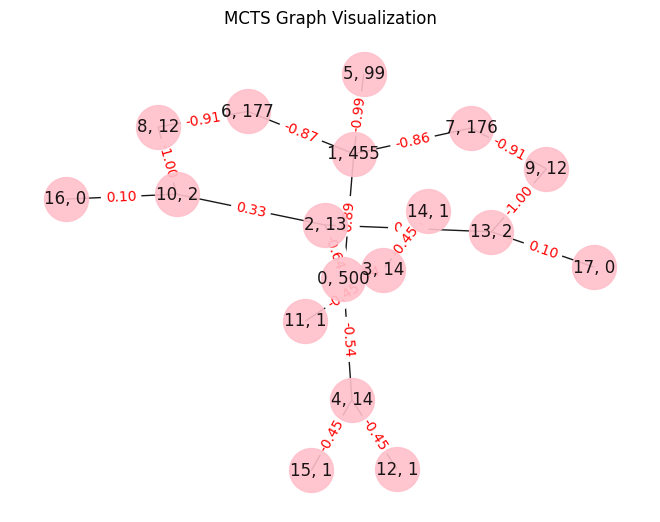

In [ ]:
root_state = np.array([1, 1,  -1, -1, 0,  0, -1,  0, 0])
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 500)

print("MCTS Expected Action Value")
print(mcts.action_mean_value[0].reshape((3,3)))

mcts.visualize_tree()

#### The code above shows the MCTS rollout for another state, in which the game can be won with a move at the center, and is lost otherwise with perfect play. The MCTS rollout correctly converges to a high value for the center move, and negative values for everything else. 

### Q1
In the limit of MCTS depth, should the tree converge to a value of 1.0 for the center move? 

### A1
No, the MCTS also values exploration, so even with infinite depth, it will still make some fraction of incorrect moves after the winning center move. 

### Q2
The tree above shows how often each state is visited, and shows the estimated value of actions stemming from each state along edges. Why do so many edges in the tree have a value of 0.1? **Hint:** Look at the outputs of the toy model. 

### A2
Value estimates of 0.1 come from states that aren't expanded further until they reach a win, loss, or draw. The only value propagated up the tree is the model's estimate for the state's value, which is always 0.1 for the toy model. 

### Q3
How should the value estimate for the center square change is the MCTS exploration rate is increased? Why? 

### A3
If we test this, we find that the value goes down. This is because the model is making more random moves, lowering the value of moves that would be a guaranteed win with perfect play. 

# Full MCTS Visualization
Tic-tac-toe is a small enough game that it's possible to plot the entire MCTS for some subsets. In the following code, we plot the states visited in MCTS, along with the number of times the tree search took actions to visit that state, and the estimated value of the action leading to this state from tree search. 

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.collections import LineCollection

# create discrete colormap
cmap = colors.ListedColormap(['red', 'grey', 'blue'])
bounds = [-2, -0.5, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

def box_pos(num_box, layer_level, spacing, offset=0.0):
    offset = spacing*offset
    draw_pos = [(i*1.5*spacing+offset, -layer_level+offset) for i in range(num_box)]
    return draw_pos

def draw_edges(ax, dp1, dp2, edges):
    # print(edges)
    segments = []
    for p, c in edges:
        segments.append(((dp1[p], dp2[c])))
    # print("segments", segments)
    line_segments = LineCollection(segments, linestyles='solid', color='red', zorder=0)
    ax.add_collection(line_segments)

def draw_layer(ax, to_print, draw_pos, spacing):
    #draw layer
    gx = np.linspace(0, 0.6, 4)
    for pos, t in zip(draw_pos, to_print):
        x, y = pos
        state, text = t
        state = state.reshape((3,3))
        ax.pcolormesh(gx*spacing+x, gx*spacing+y, state, shading='flat', cmap=cmap)
        if(spacing > 0.1):
            ax.text(x+0.65*spacing, y, text)


def plot_mcts(ax, mcts, root_index): 
    layer = [root_index]
    value, count = mcts.action_mean_value[root_index].max(), mcts.visit_count[root_index]
    to_print = [(mcts.state[root_index], f"Visits: {count}\nValue: {value:.2f}")]

    to_print_l = [to_print]
    edges_l = []

    layer_row = 0
    while len(layer) > layer.count(-1):
        next_layer = []
        to_print = []
        edges = []
        seen_states = {}
        for parent_i, state_index in enumerate(layer):
            if(state_index < 0):
                continue
            state = mcts.state[state_index]
            visited_actions, = np.nonzero(mcts.action_visits[state_index])
            visit_counts = mcts.action_visits[state_index][visited_actions]
            action_values = mcts.action_mean_value[state_index, visited_actions]
            for action, count, value in zip(visited_actions, visit_counts, action_values):
                child_state = flip_board(get_next_state(state, action))
                if(child_state.tobytes() in seen_states): #Child already in next layer
                    child_i = seen_states[child_state.tobytes()]
                    edges.append((parent_i, child_i))
                    continue

                if(child_state.tobytes() in mcts.state_lookup): #Child in MCTS
                    child_index = mcts.state_lookup[child_state.tobytes()]
                    valid_moves = get_valid_mask(child_state)
                    child_value = mcts.action_mean_value[child_index][valid_moves].max()
                    next_layer.append(child_index)
                elif(get_reward(child_state)[1]): #Child is end-state
                    next_layer.append(-1)
                    child_value = -value
                else:
                    continue

                child_i = len(to_print)
                edges.append((parent_i, child_i))
                seen_states[child_state.tobytes()] = child_i
                to_print.append((child_state, f"{count}\n{child_value:.2f}"))
        to_print_l.append(to_print)
        edges_l.append(edges)
        layer_row += 1
        layer = next_layer

    spacing_l = np.array([min(0.3, 2/(len(to_print)+1e-4)) for to_print in to_print_l])
    layer_level_l = np.cumsum(spacing_l+0.5)

    draw_pos = box_pos(len(to_print_l[0]), layer_level_l[0], spacing_l[0], offset=0.3)
    for i in range(1, len(to_print_l)):
        next_draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i], offset=0.3)
        # print(len(draw_pos), len(next_draw_pos))
        draw_edges(ax, draw_pos, next_draw_pos, edges_l[i-1])
        draw_pos = next_draw_pos
    
    for i in range(len(to_print_l)):
        draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i])
        draw_layer(ax, to_print_l[i], draw_pos, spacing_l[i])
    # draw_pos = box_pos(len(to_print), layer_level, spacing)

#### The visualization code will show how the MCTS evaluates our earlier position. The value associated with each board state is the maximum of the return from each possible action for the state. 
#### **Note**: The state flips colors each turn so that each move is considered from the perspective of the blue player. 

Board Initial State
 [[ 1  1 -1]
 [-1  0  0]
 [-1  0  0]]


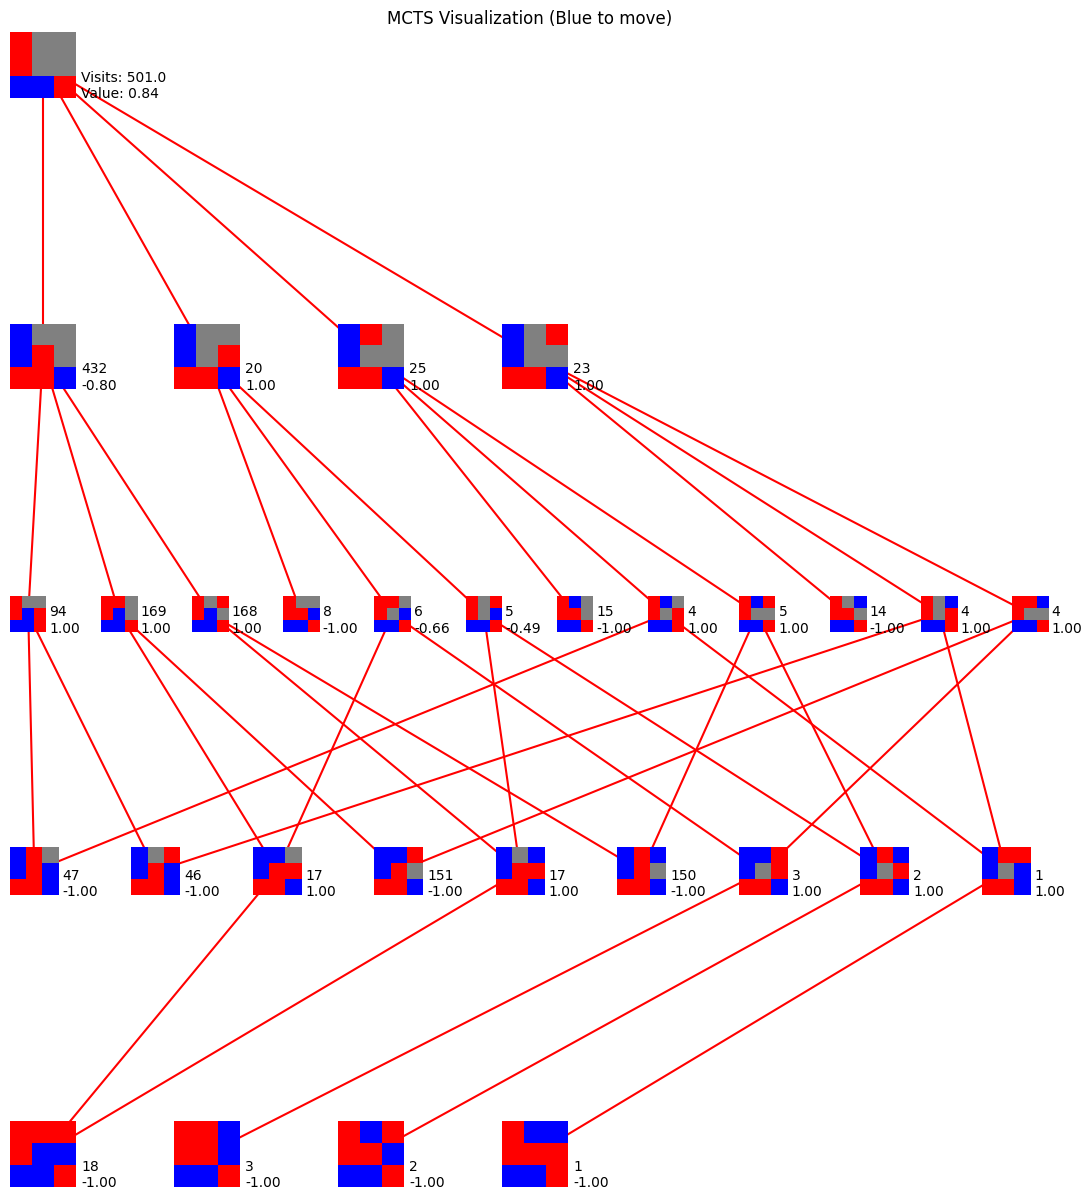

In [7]:
root_state = np.array([1, 1,  -1, -1, 0,  0, -1,  0, 0])
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 500)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
ax.set_title("MCTS Visualization (Blue to move)")
fig.show()

### High branching factor visualization

Board Initial State
 [[ 1 -1  0]
 [ 0  0  0]
 [ 0  0  0]]


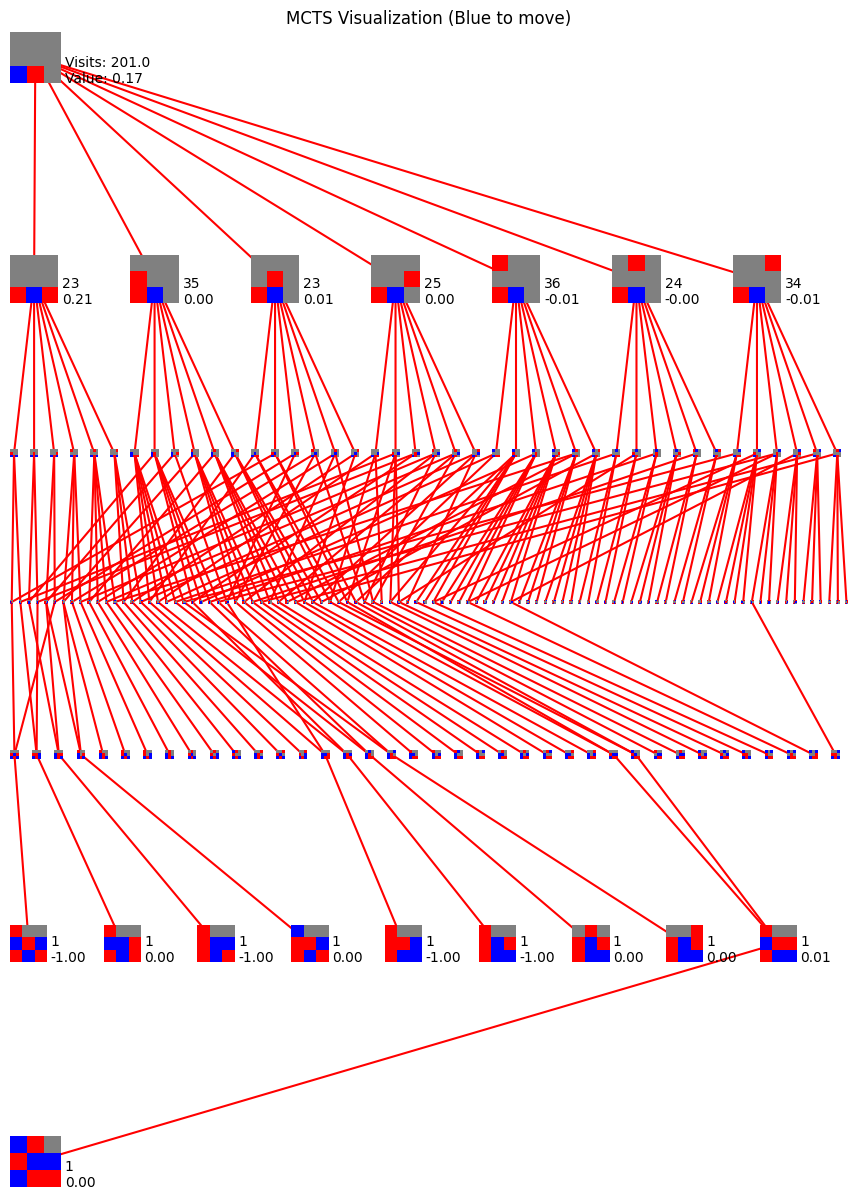

In [8]:
root_state = np.array([1, -1,  0, 0, 0,  0, 0,  0, 0])
# root_state = np.zeros(9)
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 200)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
ax.set_title("MCTS Visualization (Blue to move)")
fig.show()

### Model Training (Self-Play Episodes)
If we're convinced by our visualizations that the MCTS is correctly evaluating move quality, we can move onto training our model. The first step is to generate example games through self-play, which can be used as training data for the model. 

Implement get_action_prob for the MCTS class. In the self-play loop below, observe how get_action_prob is used to sample potentially valuable actions at each step of gameplay. 

In [18]:
def self_play_episode(model, num_sims=50, temp_threshold=6):
    train_examples = []
    board = init_board()
    step = 0
    while True:
        mcts = MCTS()
        root_index = mcts.mcts_eval(board, model, num_sims=num_sims)
        
        temp = int(step < temp_threshold)
        pi = mcts.get_action_prob(root_index, temperature=temp)

        train_examples.append((board, pi, step))

        action = np.random.choice(ACTION_DIM, p=pi)
        # print("action", action)
        
        board = flip_board(get_next_state(board, action))

        #Reward is always negative because board is flipped after move. 
        r, game_over = get_reward(board) 
        if(game_over):
            return [(b, p, r*(-1)**(step-s-1)) for b, p, s in train_examples]
        step += 1

def batch_examples(train_examples):
    state_batch = jnp.stack([t[0] for t in train_examples])
    pa_batch = jnp.stack([t[1] for t in train_examples])
    r_batch = jnp.stack([t[2] for t in train_examples]).reshape((-1, 1))
    return state_batch, pa_batch, r_batch

### Q1
The temperature parameter changes from 1 to 0 after the 6th move. What are the effects of this change? Why would they improve training? 

### A1
Temperature determines the noisyness of moves, lowering the temperature from 1 to 0 forces the model to always make the move with the highest expected value, instead of sampling from a distribution. This is almost always a good idea late in the game, when there's usually only one good move, so making the change increases the number of high quality games in training samples. 

In [20]:
train_examples = self_play_episode(toy_model, num_sims=1000)
state_b, pa_b, r_b = batch_examples(train_examples)
print("Single Game Rollout")
for b, r in zip(state_b, r_b):
    print("State\n", b.reshape((3,3)))
    print("Reward", r[0])

Single Game Rollout
State
 [[0 0 0]
 [0 0 0]
 [0 0 0]]
Reward 0.0
State
 [[ 0  0  0]
 [ 0 -1  0]
 [ 0  0  0]]
Reward 0.0
State
 [[-1  0  0]
 [ 0  1  0]
 [ 0  0  0]]
Reward 0.0
State
 [[ 1  0  0]
 [-1 -1  0]
 [ 0  0  0]]
Reward 0.0
State
 [[-1  0  0]
 [ 1  1 -1]
 [ 0  0  0]]
Reward 0.0
State
 [[ 1 -1  0]
 [-1 -1  1]
 [ 0  0  0]]
Reward 0.0
State
 [[-1  1  0]
 [ 1  1 -1]
 [ 0 -1  0]]
Reward 0.0
State
 [[ 1 -1 -1]
 [-1 -1  1]
 [ 0  1  0]]
Reward 0.0
State
 [[-1  1  1]
 [ 1  1 -1]
 [-1 -1  0]]
Reward -0.0


### Q1 
Why is the reward flipped between each state in the training rollout?

### A1
At each step of training, the state is updated, and then flipped, so that it's from the perspective of the opposing player. The reward then also has to be flipped to match. 

### Jax/Flax Training
For training, we use the Jax/Flax packages. The TTTModel takes in a tic-tac-toe board state, and needs to return two outputs, a set of logits giving the probability of making each possible move, and a value between -1 and 1 estimating the expected value of the state, with 1 representing certain victory, and -1 representing certain defeat. 

In [14]:
from jax import jit

class TTTModel(nn.Module):
  """A simple MLP model."""
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=1024)(x)
    x = nn.relu(x)
    body = nn.Dense(features=1024)(x)
    body = nn.relu(body)
    logits = nn.Dense(features=9)(body)
    value = nn.tanh(nn.Dense(features=1)(body)) #Value estimate between -1 and 1
    return logits, value

@jit
def model_agent(x, params): 
  #A version of the model that returns actual probability values instead of logits, which are usually used for numerical stability
  logits, value = TTTModel().apply(params, x)
  return nn.softmax(logits), value

model = TTTModel()
rng = jax.random.PRNGKey(42)
params = model.init(rng, board)

# Model Optimization
The reinforcement model optimizes two objectives at once. First, it attempts to match it's estimated distribution for moves with the MCTS estimate for moves by minimizing cross entropy. Second, it attempts to minimize the square error of it's value estimates against the actual values from the training rollout. Both should be optimized in train_step below.

In [15]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  model = TTTModel()
  params = model.init(rng, jnp.ones([1, 9]))['params']

  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, state_b, pa_b, r_b):
  """Train for a single step."""
  def loss_fn(params):
    logits, exp_value = TTTModel().apply({'params': params}, state_b)
    loss = optax.softmax_cross_entropy(logits, pa_b).mean() + jnp.square(r_b - exp_value).mean()
    return loss, (logits, exp_value)
  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, aux = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  # metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state#, metrics

In [16]:
def learned_agent(board, state):
    prior = model_agent(board, {'params': state.params})[0]
    prior *= get_valid_mask(board)
    return np.argmax(prior)

def random_agent(board):
    valid_mask = np.float32(get_valid_mask(board))
    valid_mask /= valid_mask.sum()
    return np.random.choice(board.shape[0], p=valid_mask)

def play_match(agent1, agent2):
    board = init_board()
    agents = [agent1, agent2]
    step = 0
    while True:
        a = agents[step%2](board)
        board = flip_board(get_next_state(board, a))
        reward, game_over = get_reward(board)
        # print(step, board)
        if(game_over):
            return reward**step
        step += 1

#Write code to evaluate the win, loss, and draw percentage of agent1 against agent2. Make sure you have equal numbers of games with
#agent1 going first or second
def match_average(agent1, agent2):
    matches = []
    for i in range(100):
        matches.append(play_match(agent1, agent2))
        matches.append(-play_match(agent2, agent1))
    return (matches.count(1)/2, matches.count(-1)/2, matches.count(0)/2)

# AlphaZero Training Loop
The alphazero training loop works by generating games with MCTS assisted self-play, and then using the results and gamestates from those games to update the model parameters. A few batches in the loop below should bring the model to around a 60% win rate against a random opponent. 

In [21]:
state = create_train_state(rng, 0.01, 0.1)
win_percentage = []
for i in range(15):
    print(f"Batch {i}")
    train_examples = []
    for i in range(10):
        train_examples += self_play_episode(lambda x: model_agent(x, {'params': state.params}), num_sims=150)
    state_b, pa_b, r_b = batch_examples(train_examples)
    state = train_step(state, state_b, pa_b, r_b)
    win, loss, draw = match_average(lambda s:learned_agent(s, state), random_agent)
    print(f"Against random: Wins {win}%, Losses {loss}%, Draws {draw}%")
    win_percentage.append(win)

Batch 0
Against random: Wins 35.5%, Losses 53.0%, Draws 11.5%
Batch 1
Against random: Wins 39.5%, Losses 47.5%, Draws 13.0%
Batch 2
Against random: Wins 42.5%, Losses 40.5%, Draws 17.0%
Batch 3
Against random: Wins 40.5%, Losses 52.0%, Draws 7.5%
Batch 4
Against random: Wins 34.5%, Losses 48.5%, Draws 17.0%
Batch 5
Against random: Wins 46.5%, Losses 48.0%, Draws 5.5%
Batch 6
Against random: Wins 43.0%, Losses 45.0%, Draws 12.0%
Batch 7
Against random: Wins 37.5%, Losses 45.5%, Draws 17.0%
Batch 8
Against random: Wins 44.5%, Losses 44.5%, Draws 11.0%
Batch 9
Against random: Wins 45.5%, Losses 42.0%, Draws 12.5%
Batch 10
Against random: Wins 48.0%, Losses 41.0%, Draws 11.0%
Batch 11
Against random: Wins 47.5%, Losses 41.0%, Draws 11.5%
Batch 12
Against random: Wins 51.5%, Losses 42.0%, Draws 6.5%
Batch 13
Against random: Wins 58.0%, Losses 33.0%, Draws 9.0%
Batch 14
Against random: Wins 59.0%, Losses 36.0%, Draws 5.0%


### Can the model prevent an instant loss?

In [22]:
model = TTTModel()

board = np.array([1, -1, 0, -1, 1, 0, -1, 0, -1])
print("Board State")
print(board.reshape((3,3)))
action_prior, value = model.apply({'params': state.params}, board)
print("Model Distribution")
print((action_prior*get_valid_mask(board)).reshape((3,3)), value)

Board State
[[ 1 -1  0]
 [-1  1  0]
 [-1  0 -1]]
Model Distribution
[[ 0.          0.         -0.1040242 ]
 [ 0.          0.         -0.28398067]
 [ 0.         -0.06562487  0.        ]] [0.13834831]


### Yes! 
The model correctly infers that the least-bad move is to block the immediate win. 

### Training directly from MCTS evaluations
The AlphaZero paper uses MCTS evaluations to guide games, which are used on their own as training data. However, for games as small as tic-tac-toe, the MCTS algorithm is able to cover a significant fraction of the state-space, making them a rich source of data on their own. Using the code framework below, try training the model directly from states and state evaluations estimated by a deep MCTS run. 

### Q1
For this simple problem setting, this approach actually trains much faster than the original to paper version shown above. Why would this approach be ineffective for more complicated games such as chess? 

### A1
Here, because of the small size of the tic-tac-toe state space, the MCTS evaluation of states and actions approximates the true optimal values. Training directly on MCTS evaluations is then similar to simply training a supervised model on a comprehensive dataset. In a game like chess, the MCTS evaluation would have the correct expected value, but would likely have very high variance. Training a model to directly predict the MCTS evaluations would mean teaching the model to predict the noise, in addition to the signal. 

In [23]:
def sample_state(mcts, visited_states):
    index = np.random.choice(visited_states)
    state = mcts.state[index]
    valid_mask = get_valid_mask(state)
    action_value = mcts.action_mean_value[index]# - valid_mask*1e4
    action_visits = mcts.action_visits[index]
    action_visits = action_visits / action_visits.sum()
    return state, action_visits, action_value[valid_mask].max()

mcts = MCTS(max_size=5001, exp_rate=2.1)
root_state = init_board()
mcts.mcts_eval(root_state, toy_model, num_sims=5000)
visited_states = np.arange(0, mcts.state.shape[0])[(mcts.visit_count > 4)]
print(sample_state(mcts, visited_states))

def sample_batch(mcts, visited_states, batch_size=100):
    res = []
    for i in range(batch_size):
        res.append(sample_state(mcts, visited_states))
    return batch_examples(res)

(array([-0., -1., -1., -1., -1.,  1.,  1.,  1., -0.]), array([0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75]), 1.0)


In [26]:
state = create_train_state(rng, 0.005, 0.1)
win_percentage = []
for i in range(5):
    mcts = MCTS(max_size=20001, exp_rate=2.1)
    root_state = init_board()
    mcts.mcts_eval(root_state, lambda x: model_agent(x, {'params': state.params}), num_sims=20000)
    visited_states = np.arange(0, mcts.state.shape[0])[(mcts.visit_count > 4)]
    for j in range(500):
        state_b, pa_b, r_b = sample_batch(mcts, visited_states, batch_size=100)
        state = train_step(state, state_b, pa_b, r_b)
    print(f"Epoch {i}")
    win, loss, draw = match_average(lambda s:learned_agent(s, state), random_agent)
    print(f"Against random: Wins {win}%, Losses {loss}%, Draws {draw}%")
    win_percentage.append(win)

Epoch 0
Against random: Wins 46.5%, Losses 41.5%, Draws 12.0%
Epoch 1
Against random: Wins 62.0%, Losses 28.5%, Draws 9.5%
Epoch 2
Against random: Wins 76.0%, Losses 16.0%, Draws 8.0%
Epoch 3
Against random: Wins 83.5%, Losses 12.5%, Draws 4.0%
Epoch 4
Against random: Wins 81.0%, Losses 12.0%, Draws 7.0%


In [ ]:
plt.plot(win_percentage)
plt.title("MCTS Model Win-Rate / Epoch")
plt.xlabel("Epoch")
plt.ylabel("Win-Rate (Percent)")
plt.show()

# Can the model select an instant win? 

In [25]:
model = TTTModel()
board = np.array([1, 1, 0, -1, -1, 0, -1, 0, -1])
print("Board State")
print(board.reshape((3,3)))
action_prior, value = model.apply({'params': state.params}, board)
print("Model Distribution")
print((action_prior*get_valid_mask(board)).reshape((3,3)), value)

Board State
[[ 1  1  0]
 [-1 -1  0]
 [-1  0 -1]]
Model Distribution
[[0.         0.         3.1874137 ]
 [0.         0.         0.87226486]
 [0.         0.01971844 0.        ]] [0.5989371]


### Evaluating Model Performance
Using either the default AlphaZero algorithm, or direct MCTS training, we can estimate the relative performance of the model by simulating games against naive agents, or look-ahead agents that estimate the value of each move with traditional tree search. 

The learned agent should consistently beat random agents, and should be on par with normal tree search. The best performing model should be the learned model integrated into tree search as a heuristic, as is used by AlphaZero for the highest performance. 

In [ ]:
def mcts_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, lambda x: model_agent(x, {'params': state.params}), num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

def mcts_rand_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, toy_model, num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

[[ 1 -1  0]
 [-1  1  0]
 [-1  0 -1]]
[[-0.06947386  0.9074846  -0.7985181 ]
 [ 0.01734072  0.22672863 -1.6447791 ]
 [ 0.17377917  0.6774679   0.01282568]] [-0.2242376]


In [ ]:
fig, axis = plt.subplots()
match_results = []
for i in range(1000):
    match_results.append(play_match(lambda s:learned_agent(s, state), random_agent))
    match_results.append(-play_match(random_agent, lambda s:learned_agent(s, state)))

counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent vs Random")
fig.show()

fig, axis = plt.subplots()
match_results = []
for i in range(1000):
    match_results.append(play_match(lambda s:learned_agent(s, state), mcts_rand_agent))
    match_results.append(-play_match(mcts_rand_agent, lambda s:learned_agent(s, state)))

counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent vs Naive MCTS")
fig.show()

fig, axis = plt.subplots()
match_results = []
for i in range(100):
    match_results.append(play_match(mcts_agent, random_agent))
    match_results.append(-play_match(random_agent, mcts_agent))

counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent (w/ MCTS) vs Random")
fig.show()

match_results = []
for i in range(100):
    match_results.append(play_match(mcts_agent, mcts_rand_agent))
    match_results.append(-play_match(mcts_rand_agent, mcts_agent))

fig, axis = plt.subplots()
counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent (w/ MCTS) vs Random")
fig.show()
